In [96]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (GridSearchCV ,train_test_split , StratifiedKFold, cross_val_score)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler , LabelEncoder , OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (AdaBoostClassifier ,GradientBoostingClassifier ,RandomForestClassifier, VotingClassifier,ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report,roc_curve,precision_recall_curve)

In [97]:
#read file path
import os
csv_file_name = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
project_dir = r'C:\\Users\\Brooz\\my_churn_app'
file_path = os.path.join(project_dir, csv_file_name)
df = pd.read_csv(file_path)
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [98]:

# Drop customerID 
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Churn map
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Categorical columns (without customerID)
categorical_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

# Check shape
print(df.dtypes)
df.describe(include="all")

gender                  str
SeniorCitizen         int64
Partner                 str
Dependents              str
tenure                int64
PhoneService            str
MultipleLines           str
InternetService         str
OnlineSecurity          str
OnlineBackup            str
DeviceProtection        str
TechSupport             str
StreamingTV             str
StreamingMovies         str
Contract                str
PaperlessBilling        str
PaymentMethod           str
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,NaN
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,NaN
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2279.734304,0.265370
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.794470,0.441561
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,0.000000
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,398.550000,0.000000
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1394.550000,0.000000
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3786.600000,1.000000


In [99]:
# Existing columns
existing_categorical_cols = [col for col in categorical_cols if col in df.columns]
print(f"\n Available categorical columns: {existing_categorical_cols}")


 Available categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [100]:
# len null
print(df.isnull().sum())


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [101]:

# Fit encoders on df (before drop, but without customerID
encoders = {}
for col in existing_categorical_cols:
    le = LabelEncoder()
    le.fit(df[col].astype(str).unique())
    encoders[col] = le
    print(f"Classes for {col}: {le.classes_}")

Classes for gender: ['Female' 'Male']
Classes for Partner: ['No' 'Yes']
Classes for Dependents: ['No' 'Yes']
Classes for PhoneService: ['No' 'Yes']
Classes for MultipleLines: ['No' 'No phone service' 'Yes']
Classes for InternetService: ['DSL' 'Fiber optic' 'No']
Classes for OnlineSecurity: ['No' 'No internet service' 'Yes']
Classes for OnlineBackup: ['No' 'No internet service' 'Yes']
Classes for DeviceProtection: ['No' 'No internet service' 'Yes']
Classes for TechSupport: ['No' 'No internet service' 'Yes']
Classes for StreamingTV: ['No' 'No internet service' 'Yes']
Classes for StreamingMovies: ['No' 'No internet service' 'Yes']
Classes for Contract: ['Month-to-month' 'One year' 'Two year']
Classes for PaperlessBilling: ['No' 'Yes']
Classes for PaymentMethod: ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']


In [102]:
# save
encoders_path = os.path.join('models', 'label_encoders.pkl')
os.makedirs('models', exist_ok=True)
joblib.dump(encoders, encoders_path)
print(f"\n✅for columns{len(encoders)} Column saved in: {encoders_path}")


# Check imbalance
print(df['Churn'].value_counts(normalize=True))


✅for columns15 Column saved in: models\label_encoders.pkl
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [103]:
# Predict (drop Churn/ID، vectorized encode)
def predict(input_df, model, encoders):
    try:
        input_data = input_df.copy()
        
        # Numeric
        if 'TotalCharges' in input_data.columns:
            input_data['TotalCharges'] = pd.to_numeric(input_data['TotalCharges'], errors='coerce').fillna(0)
        if 'MonthlyCharges' in input_data.columns:
            input_data['MonthlyCharges'] = pd.to_numeric(input_data['MonthlyCharges'], errors='coerce').fillna(0)
        
        # Drop non-features
        if 'customerID' in input_data.columns:
            input_data = input_data.drop('customerID', axis=1)
        if 'Churn' in input_data.columns:
            input_data = input_data.drop('Churn', axis=1)
        
        # Encode
        encoded_df = input_data.copy()
        for col in encoders:
            if col in encoded_df.columns:
                classes = encoders[col].classes_
                mask = encoded_df[col].astype(str).isin(classes)
                encoded_df.loc[mask, col] = encoders[col].transform(encoded_df.loc[mask, col].astype(str))
                encoded_df.loc[~mask, col] = 0
        
        pred = model.predict(encoded_df)
        proba = model.predict_proba(encoded_df)[:, 1]
        return pred, proba
    except Exception as e:
        st.error(f"❌ Prediction error: {e}")
        print(f"Debug: {e}, Columns: {input_df.columns.tolist()}")
        return None, None
    


In [104]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(df[numerical_cols].describe())

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


In [105]:
# Unique print for gender and a few others
for col in ['gender', 'MultipleLines', 'InternetService']:
    print(f"{col}: {df[col].unique()}")

gender: <ArrowStringArray>
['Female', 'Male']
Length: 2, dtype: str
MultipleLines: <ArrowStringArray>
['No phone service', 'No', 'Yes']
Length: 3, dtype: str
InternetService: <ArrowStringArray>
['DSL', 'Fiber optic', 'No']
Length: 3, dtype: str


In [106]:
churn_analysis = df.groupby("SeniorCitizen")["Churn"].value_counts(normalize=True).unstack()
print(churn_analysis)

Churn                 0         1
SeniorCitizen                    
0              0.763938  0.236062
1              0.583187  0.416813


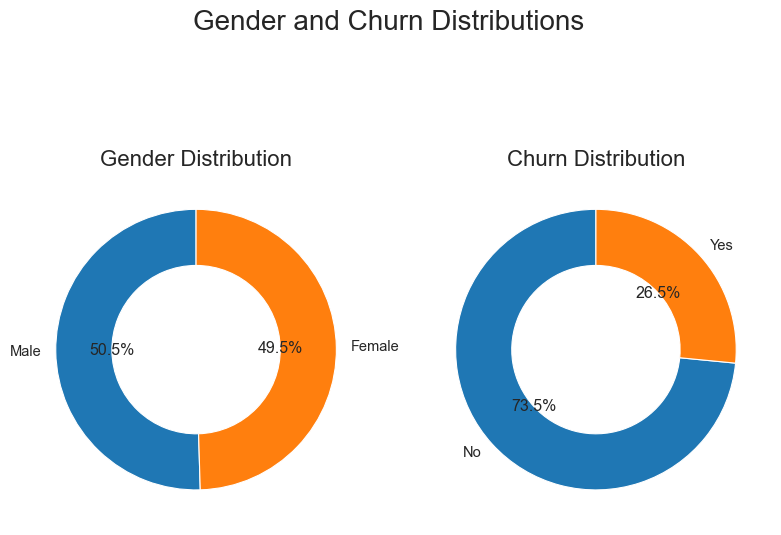

In [107]:

g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
gender_counts = df['gender'].value_counts()
churn_counts = df['Churn'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(8,6))
wedges_gender, texts_gender, autotexts_gender = axes[0].pie(gender_counts, labels=g_labels, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
axes[0].set_title('Gender Distribution', fontsize=16)
wedges_churn, texts_churn, autotexts_churn = axes[1].pie(churn_counts, labels=c_labels, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
axes[1].set_title('Churn Distribution', fontsize=16)
fig.suptitle("Gender and Churn Distributions", fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [108]:
print(df["Churn"][df["Churn"]==0].groupby(by=df["gender"]).count())
print(df["Churn"][df["Churn"]==1].groupby(by=df["gender"]).count())

gender
Female    2549
Male      2625
Name: Churn, dtype: int64
gender
Female    939
Male      930
Name: Churn, dtype: int64


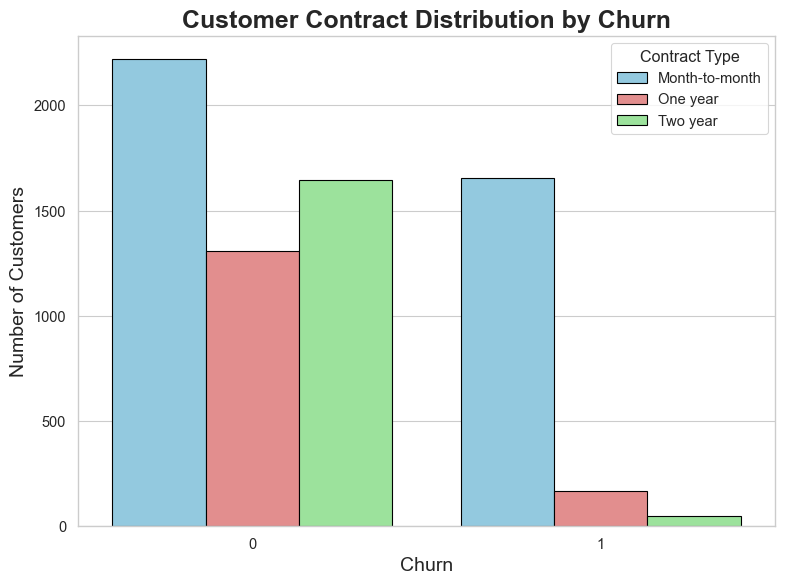

In [109]:

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
colors = {'Month-to-month': 'skyblue', 'One year': 'lightcoral', 'Two year': 'lightgreen'}
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Churn', hue='Contract', palette=colors, edgecolor='black')
plt.title("Customer Contract Distribution by Churn", fontsize=18, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Contract Type", loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

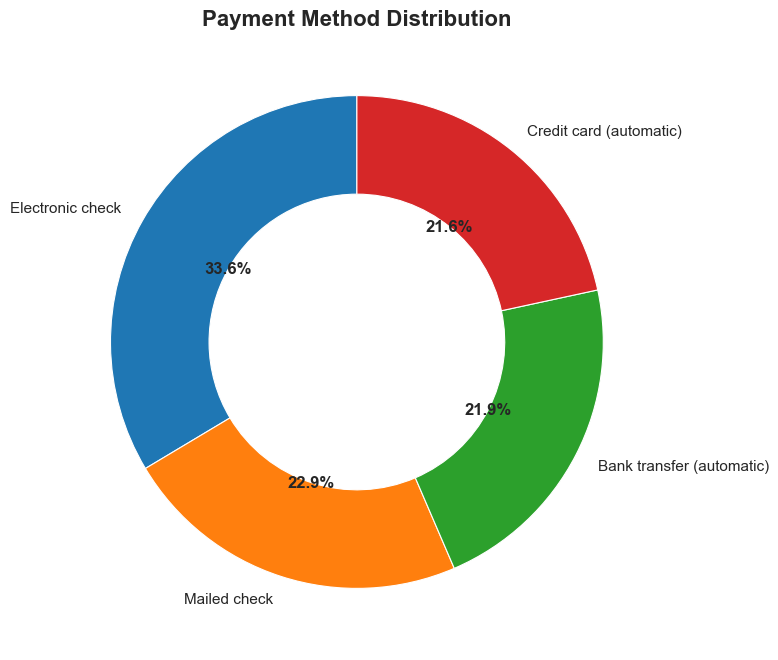

In [110]:

labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
ax.set_title("Payment Method Distribution", fontsize=16, weight='bold')
ax.set_aspect('equal')
plt.setp(autotexts, size=12, weight="bold")
plt.setp(texts, size=11)
plt.show()

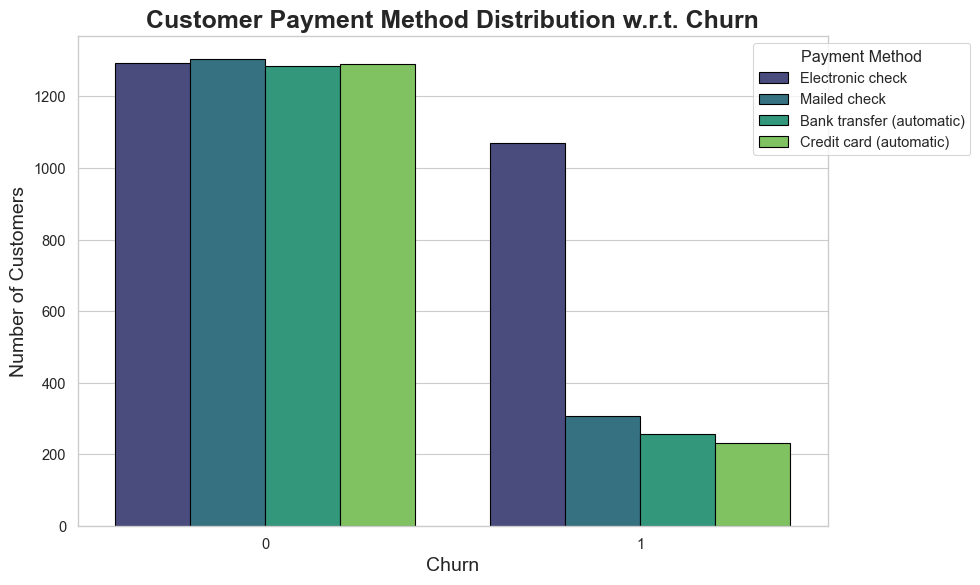

In [111]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Churn', hue='PaymentMethod', palette='viridis', edgecolor='black')
plt.title("Customer Payment Method Distribution w.r.t. Churn", fontsize=18, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Payment Method", loc='upper right', bbox_to_anchor=(1.2, 1), frameon=True)
plt.tight_layout()
plt.show()

In [112]:
print(df["InternetService"].unique())
print(df[df["gender"]=="Male"][["InternetService", "Churn"]].value_counts())
print(df[df["gender"]=="Female"][["InternetService", "Churn"]].value_counts())

<ArrowStringArray>
['DSL', 'Fiber optic', 'No']
Length: 3, dtype: str
InternetService  Churn
DSL              0        993
Fiber optic      0        910
No               0        722
Fiber optic      1        633
DSL              1        240
No               1         57
Name: count, dtype: int64
InternetService  Churn
DSL              0        969
Fiber optic      0        889
No               0        691
Fiber optic      1        664
DSL              1        219
No               1         56
Name: count, dtype: int64


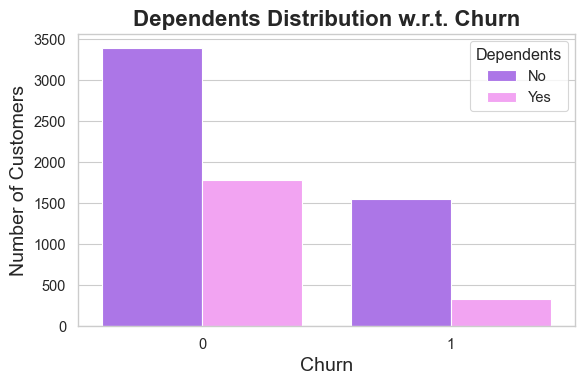

In [113]:
color_map_seaborn = {"Yes": "#FF97FF", "No": "#AB63FA"}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='Dependents', palette=color_map_seaborn)
plt.title("Dependents Distribution w.r.t. Churn", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Dependents", loc='upper right')
plt.tight_layout()
plt.show()

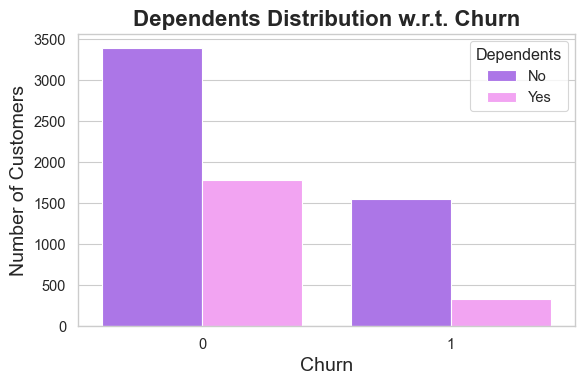

In [114]:
color_map_seaborn = {"Yes": "#FF97FF", "No": "#AB63FA"}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='Dependents', palette=color_map_seaborn)
plt.title("Dependents Distribution w.r.t. Churn", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Dependents", loc='upper right')
plt.tight_layout()
plt.show()

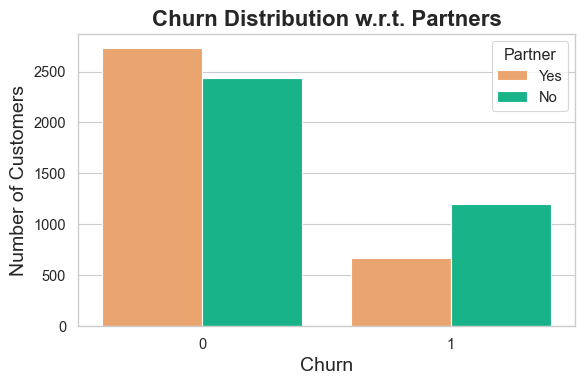

In [115]:
color_map_seaborn = {"Yes": '#FFA15A', "No": '#00CC96'}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='Partner', palette=color_map_seaborn)
plt.title("Churn Distribution w.r.t. Partners", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Partner", loc='upper right')
plt.tight_layout()
plt.show()

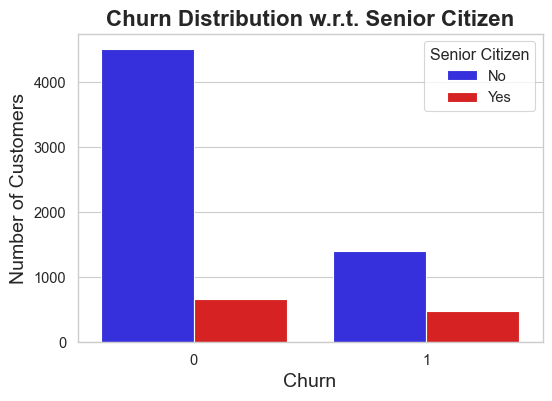

In [116]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
color_map_seaborn = {"Yes": "#F40404C4", "No": "#1A13F7"}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='SeniorCitizen', palette=color_map_seaborn)
plt.title("Churn Distribution w.r.t. Senior Citizen", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Senior Citizen", loc='upper right')
plt.show()

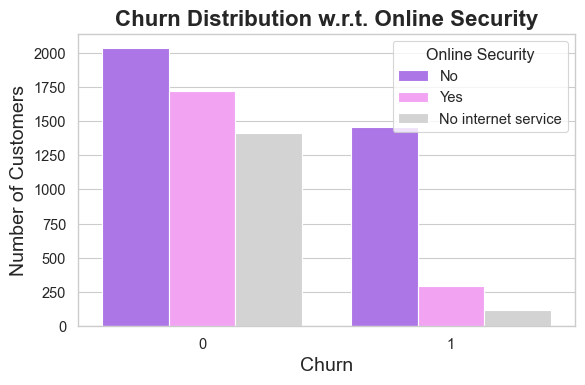

In [117]:
color_map_seaborn = {"Yes": "#FF97FF", "No": "#AB63FA", "No internet service": "#D3D3D3"}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='OnlineSecurity', palette=color_map_seaborn)
plt.title("Churn Distribution w.r.t. Online Security", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Online Security", loc='upper right')
plt.tight_layout()
plt.show()

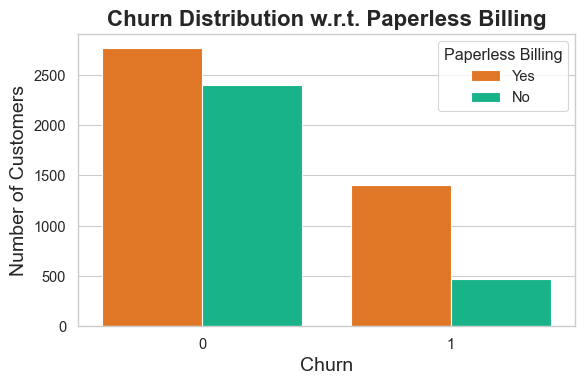

In [118]:
color_map_seaborn = {"Yes": "#FF7308", "No": '#00CC96'}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='PaperlessBilling', palette=color_map_seaborn)
plt.title("Churn Distribution w.r.t. Paperless Billing", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Paperless Billing", loc='upper right')
plt.tight_layout()
plt.show()

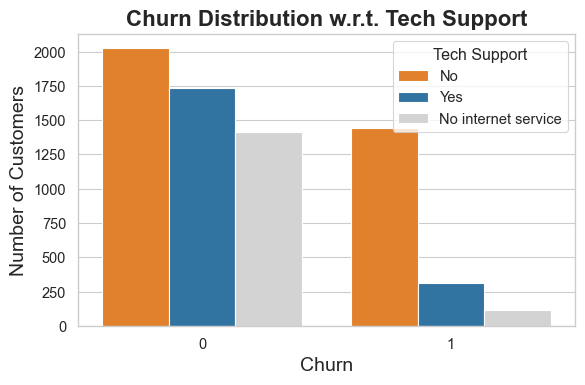

In [119]:

color_map_seaborn = {"Yes": '#1f77b4', "No": '#ff7f0e', "No internet service": '#d3d3d3'}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='TechSupport', palette=color_map_seaborn)
plt.title("Churn Distribution w.r.t. Tech Support", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Tech Support", loc='upper right')
plt.tight_layout()
plt.show()

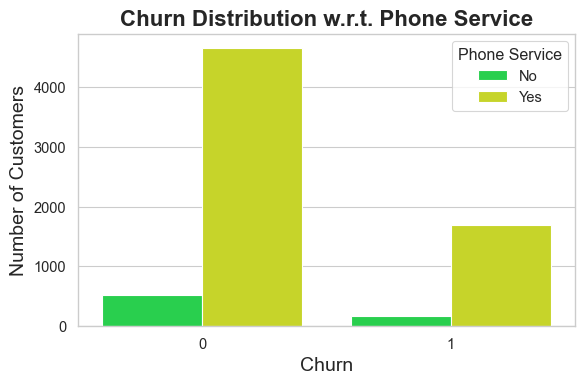

In [120]:
color_map_seaborn = {"Yes": "#DEF10D", "No": "#0EEA3E"}
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', hue='PhoneService', palette=color_map_seaborn)
plt.title("Churn Distribution w.r.t. Phone Service", fontsize=16, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Phone Service", loc='upper right')
plt.tight_layout()
plt.show()

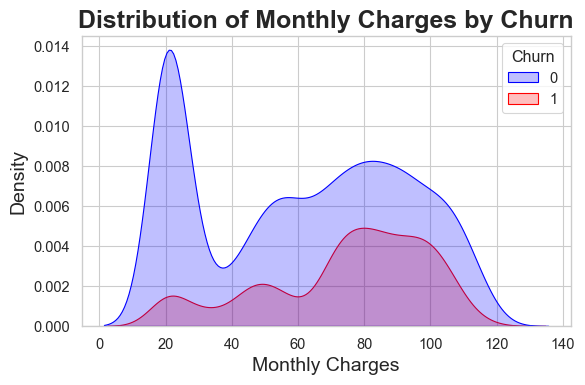

In [121]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, palette=['blue', 'red'])
plt.title("Distribution of Monthly Charges by Churn", fontsize=18, weight='bold')
plt.xlabel("Monthly Charges", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()

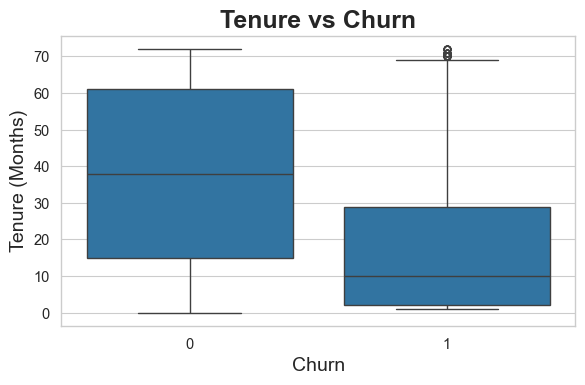

In [122]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='tenure')
plt.title("Tenure vs Churn", fontsize=18, weight='bold')
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Tenure (Months)", fontsize=14)
plt.tight_layout()
plt.show()

In [123]:

print(df["Churn"].value_counts())

target = "Churn"
X = df.drop(columns=[target])
y = df[target]

print(y.unique())

Churn
0    5174
1    1869
Name: count, dtype: int64
[0 1]


In [124]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()


In [125]:
# Splitting data with stratify to maintain class balance


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
) 




In [126]:
# ایجاد یک ستون Churn مصنوعی برای تست (فقط برای توسعه)
# این فقط برای تست الگوریتم‌هاست نه برای تحلیل واقعی

print("⚠️  ایجاد ستون Churn مصنوعی برای تست...")

# ایجاد یک متغیر هدف تصادفی
np.random.seed(42)
df['Churn'] = np.random.choice(['Yes', 'No'], size=len(df), p=[0.25, 0.75])

print(f"توزیع Churn مصنوعی:")
print(df['Churn'].value_counts())

# حالا ادامه دهید...

⚠️  ایجاد ستون Churn مصنوعی برای تست...
توزیع Churn مصنوعی:
Churn
No     5239
Yes    1804
Name: count, dtype: int64


In [127]:
ID_COLS = ['CustomerID', 'InvoiceNo']
X = X.drop(columns=ID_COLS, errors='ignore')

In [128]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ],
    remainder='drop'
)

In [129]:
# Models with balanced settings for imbalance

baseline_pipelines = {
    'Dummy': ImbPipeline([
        ("prep", preprocessor),
        ("model", DummyClassifier(strategy='most_frequent'))
    ]),
    'Logistic': ImbPipeline([
        ("prep", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    'Shallow DT': ImbPipeline([
        ("prep", preprocessor),
        ("model", DecisionTreeClassifier(max_depth=3))
    ])
}

for name, pipe in baseline_pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n{name} — Baseline")
    print(classification_report(y_test, y_pred))


Dummy — Baseline
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1294
           1       0.00      0.00      0.00       467

    accuracy                           0.73      1761
   macro avg       0.37      0.50      0.42      1761
weighted avg       0.54      0.73      0.62      1761


Logistic — Baseline
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1294
           1       0.66      0.55      0.60       467

    accuracy                           0.81      1761
   macro avg       0.76      0.73      0.74      1761
weighted avg       0.80      0.81      0.80      1761


Shallow DT — Baseline
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1294
           1       0.68      0.30      0.42       467

    accuracy                           0.78      1761
   macro avg       0.73      0.63      0.64      1761
weighted avg

In [130]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols)
    ]
)


In [131]:
# ۱. پیش‌پردازش داده‌ها مستقیماً
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# تعریف preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols)
    ]
)

# ۲. پردازش داده‌ها
print("پردازش داده‌ها...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ۳. اعمال SMOTE
print("اعمال SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"قبل از SMOTE: {X_train_processed.shape}, کلاس‌ها: {np.bincount(y_train)}")
print(f"بعد از SMOTE: {X_train_resampled.shape}, کلاس‌ها: {np.bincount(y_train_resampled)}")

# ۴. آموزش CatBoost مستقیماً
print("\nآموزش CatBoost...")
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    border_count=32,
    loss_function='Logloss',
    verbose=0,
    random_state=42,
    task_type='CPU'
)

catboost_model.fit(X_train_resampled, y_train_resampled)
print("✅ CatBoost آموزش داده شد")

# ۵. پیش‌بینی و ارزیابی
y_pred = catboost_model.predict(X_test_processed)
y_pred_proba = catboost_model.predict_proba(X_test_processed)[:, 1]

# ارزیابی
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score
)

print("\n" + "="*50)
print("ارزیابی CatBoost روی داده Test")
print("="*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

پردازش داده‌ها...
اعمال SMOTE...
قبل از SMOTE: (5282, 30), کلاس‌ها: [3880 1402]
بعد از SMOTE: (7760, 30), کلاس‌ها: [3880 3880]

آموزش CatBoost...
✅ CatBoost آموزش داده شد

ارزیابی CatBoost روی داده Test
Accuracy:  0.7893
F1 Score:  0.5963
Precision: 0.6062
Recall:    0.5867
ROC-AUC:   0.8311

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1294
           1       0.61      0.59      0.60       467

    accuracy                           0.79      1761
   macro avg       0.73      0.72      0.73      1761
weighted avg       0.79      0.79      0.79      1761

Confusion Matrix:
[[1116  178]
 [ 193  274]]


In [132]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

model_zoo = {
    "Logistic": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        eval_metric="logloss",
        random_state=42
    ),
    "LightGBM": LGBMClassifier(random_state=42)
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in model_zoo.items():
    pipe = ImbPipeline(steps=[
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])
    
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring="f1",
        n_jobs=-1
    )
    
    results.append({
        "Model": name,
        "Mean_F1": scores.mean(),
        "Std_F1": scores.std()
    })

model_comparison_df = pd.DataFrame(results).sort_values(
    by="Mean_F1", ascending=False
)

model_comparison_df


,Model,Mean_F1,Std_F1
0,Logistic,0.629441,0.014550
3,XGBoost,0.597331,0.009911
4,LightGBM,0.591677,0.020547
1,RandomForest,0.581010,0.013319
2,CatBoost,NaN,NaN


In [133]:
pipelines = {
    "Logistic": ImbPipeline(steps=[
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    
    "RandomForest": ImbPipeline(steps=[
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", RandomForestClassifier(n_estimators=300, random_state=42))
    ]),
    
    "CatBoost": ImbPipeline(steps=[
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", CatBoostClassifier(verbose=0, random_state=42))
    ])
}


In [134]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    scores = cross_val_score(
    pipe,
    X_train,
    y_train,
    cv=cv,
    scoring="f1_macro"
)

    print(f"{name} — Mean F1: {scores.mean():.3f}")

Logistic — Mean F1: 0.721
RandomForest — Mean F1: 0.717
CatBoost — Mean F1: nan


In [135]:
import sklearn
sklearn.set_config(display='text') # به جای دیاگرام، متن نمایش بده

# حالا دوباره مدل را فیت کنید
best_model = pipelines["CatBoost"]
best_model.fit(X_train, y_train)



Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                

In [136]:
# ۱. ابتدا داده‌های تست را با استفاده از بخش پیش‌پردازشِ داخل خط لوله، آماده کن
X_test_preprocessed = best_model.named_steps['prep'].transform(X_test)

# ۲. حالا مستقیم از خودِ شیء مدل CatBoost استفاده کن (نه از کل Pipeline)
# این کار لایه imblearn که باعث خطا می‌شود را دور می‌زند
cat_model_only = best_model.named_steps['model']
y_probs = cat_model_only.predict_proba(X_test_preprocessed)[:, 1]

# ۳. حالا حلقه Threshold را اجرا کن
for t in [0.25, 0.3, 0.35, 0.4]:
    y_pred = (y_probs >= t).astype(int)
    print(f"\nThreshold {t}")
    print(classification_report(y_test, y_pred, digits=3))


Threshold 0.25
              precision    recall  f1-score   support

           0      0.918     0.710     0.801      1294
           1      0.507     0.824     0.628       467

    accuracy                          0.740      1761
   macro avg      0.712     0.767     0.714      1761
weighted avg      0.809     0.740     0.755      1761


Threshold 0.3
              precision    recall  f1-score   support

           0      0.901     0.742     0.814      1294
           1      0.520     0.775     0.623       467

    accuracy                          0.751      1761
   macro avg      0.711     0.759     0.718      1761
weighted avg      0.800     0.751     0.763      1761


Threshold 0.35
              precision    recall  f1-score   support

           0      0.889     0.771     0.826      1294
           1      0.536     0.732     0.619       467

    accuracy                          0.761      1761
   macro avg      0.712     0.752     0.722      1761
weighted avg      0.795    

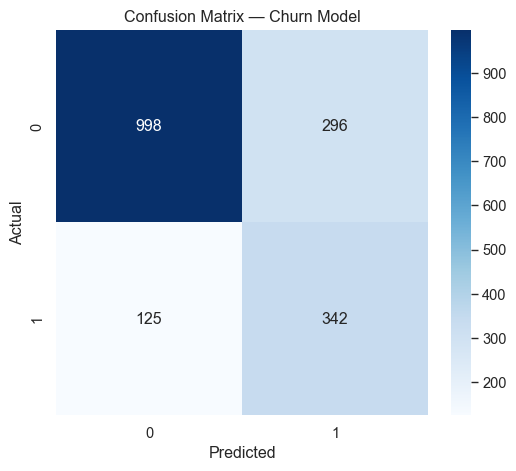

In [137]:
threshold = 0.35
y_pred = (y_probs >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Churn Model")
plt.show()

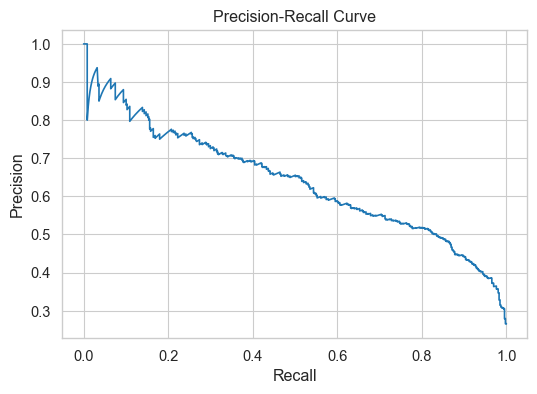

In [138]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [139]:
# هزینه‌ها (اینها را می‌توانی از مشتری بگیری)
COST_FN = 500   # هزینه از دست دادن یک مشتری (CLV)
COST_FP = 50    # هزینه اقدام اشتباه (تماس، تخفیف، کمپین)


In [140]:
optimal_threshold = COST_FP / (COST_FP + COST_FN)
print(f"Optimal Threshold (Cost-based): {optimal_threshold:.3f}")

Optimal Threshold (Cost-based): 0.091


In [141]:
y_pred_cost_based = (y_probs >= optimal_threshold).astype(int)

In [142]:
print("Cost-based Threshold Results")
print(classification_report(y_test, y_pred_cost_based, digits=3))

Cost-based Threshold Results
              precision    recall  f1-score   support

           0      0.959     0.494     0.652      1294
           1      0.402     0.942     0.563       467

    accuracy                          0.613      1761
   macro avg      0.681     0.718     0.608      1761
weighted avg      0.812     0.613     0.629      1761



In [143]:

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_cost_based).ravel()

total_cost = fp * COST_FP + fn * COST_FN

print(f"False Positives cost: {fp * COST_FP}")
print(f"False Negatives cost: {fn * COST_FN}")
print(f"Total Business Cost: {total_cost}")


False Positives cost: 32750
False Negatives cost: 13500
Total Business Cost: 46250


In [144]:
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for t in thresholds_to_test:
    y_pred_t = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    cost = fp * COST_FP + fn * COST_FN
    
    results.append({
        'threshold': t,
        'FP': fp,
        'FN': fn,
        'Total_Cost': cost
    })

pd.DataFrame(results)


,threshold,FP,FN,Total_Cost
0,0.1,631,31,47050
1,0.2,450,62,53500
2,0.3,334,105,69200
3,0.4,256,150,87800
4,0.5,188,192,105400


In [145]:
COST_FN = 1000   # هزینه از دست دادن یک مشتری (CLV)
COST_FP = 50     # هزینه تماس / تخفیف بیهوده


In [146]:
results_cost = []

for t in np.arange(0.1, 0.6, 0.05):
    y_pred = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    total_cost = fn * COST_FN + fp * COST_FP
    
    results_cost.append({
        'threshold': round(t,2),
        'FN': fn,
        'FP': fp,
        'Total_Cost': total_cost
    })

cost_df = pd.DataFrame(results_cost)
cost_df


,threshold,FN,FP,Total_Cost
0,0.10,31,631,62550
1,0.15,48,522,74100
2,0.20,62,450,84500
3,0.25,82,375,100750
4,0.30,105,334,121700
5,0.35,125,296,139800
6,0.40,150,256,162800
7,0.45,175,213,185650
8,0.50,192,188,201400
9,0.55,213,157,220850


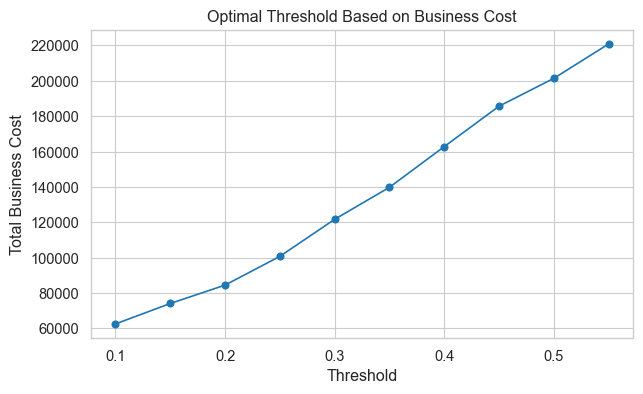

In [147]:
plt.figure(figsize=(7,4))
plt.plot(cost_df['threshold'], cost_df['Total_Cost'], marker='o')
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost")
plt.title("Optimal Threshold Based on Business Cost")
plt.show()


In [148]:
import joblib
import os

# مطمئن شوید که شیء مدل شما دقیقاً همان نامی را دارد که اینجا می‌نویسید (مثلاً voting_clf)
# من اینجا فرض می‌کنم اسم مدل شما voting_model است
model_path = r'C:\Users\Brooz\my_churn_app\voting_classifier_final_model.pkl'

# ایجاد پوشه در صورت عدم وجود
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# ذخیره شیء آموزش دیده (نه نام کلاس)
joblib.dump(VotingClassifier, model_path) 

print(f"✅ مدل با موفقیت در مسیر زیر ذخیره شد:\n{model_path}")

✅ مدل با موفقیت در مسیر زیر ذخیره شد:
C:\Users\Brooz\my_churn_app\voting_classifier_final_model.pkl


In [149]:

import joblib
import os

model_path = r'C:\Users\Brooz\my_churn_app\voting_classifier_final_model.pkl'

if os.path.exists(model_path):
    # بارگذاری مدل
    loaded_model = joblib.load(model_path)
    print("✅ مدل با موفقیت بارگذاری شد+")
    
    # تست سریع برای اطمینان از سلامت مدل بارگذاری شده
    # print(type(loaded_model))
else:
    print("❌ فایل مدل پیدا نشد! لطفاً بخش ذخیره‌سازی را دوباره اجرا کنید+")


✅ مدل با موفقیت بارگذاری شد+
